# 💡 Camera Calibration and Lens Distortion Correction in OpenCV

Camera calibration is essential for accurate computer vision tasks, as real cameras deviate from the ideal pinhole model due to lens distortions and manufacturing imperfections. This process estimates the camera's intrinsic parameters, distortion coefficients, and extrinsic parameters to correct images and enable precise measurements.

---

## 🔹 Why Camera Calibration Matters

Without calibration:
- Measurements in the real world are inaccurate.
- Augmented reality overlays may drift.
- Homography and Perspective-n-Point (PnP) solutions become unstable.
- Stereo vision depth maps collapse or show errors.



Calibration provides:
- **Intrinsic Matrix (K):** Describes the camera's internal parameters.
- **Distortion Coefficients (D):** Models radial and tangential distortions.
- **Extrinsic Parameters (R, t):** Rotation and translation per calibration image.

## 🔹 Mathematical Core: Camera Projection Model

### 1. Ideal Pinhole Model
A 3D world point $P_w = (X, Y, Z)$ projects to a 2D image point $(u, v)$:

$$s \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \mathbf{K} [\mathbf{R} | \mathbf{t}] \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}$$

Where:
- $\mathbf{R}$: $3\times3$ rotation matrix.
- $\mathbf{t}$: $3\times1$ translation vector.
- $s$: Scale factor.
- $\mathbf{K}$: Intrinsic matrix.



### 2. Intrinsic Matrix
$$\mathbf{K} = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$$

- $f_x, f_y$: Focal lengths in pixels (along x and y axes).
- $c_x, c_y$: Principal point (optical center) in pixels.

### 3. Lens Distortion Model (Brown-Conrady)
OpenCV models distortions with up to 8 coefficients:
$$\mathbf{D} = (k_1, k_2, p_1, p_2, k_3 [, k_4, k_5, k_6])$$

**Radial Distortion** (barrel/pincushion):
$$x_{dist} = x (1 + k_1 r^2 + k_2 r^4 + k_3 r^6)$$
$$y_{dist} = y (1 + k_1 r^2 + k_2 r^4 + k_3 r^6)$$

**Tangential Distortion** (lens misalignment):
$$x_{dist} = x + [2 p_1 x y + p_2 (r^2 + 2 x^2)]$$
$$y_{dist} = y + [p_1 (r^2 + 2 y^2) + 2 p_2 x y]$$

Where $r^2 = x^2 + y^2$ (normalized coordinates).

## 🔹 Calibration Strategy: Chessboard Method

Use a printed chessboard pattern for known 3D points (object points). Detect 2D corners in multiple images to solve for parameters.



- **Why Chessboard?** High-contrast corners for sub-pixel accuracy, known geometry.
- **Requirements:** At least 10-20 images from different angles/positions (avoid coplanar views).
- Map known 3D object points to detected 2D image points.

In [11]:
# Imports and setup
import cv2
import numpy as np
import os
import glob
from tools.tools import LearnTools

learn_tools = LearnTools()
%matplotlib inline

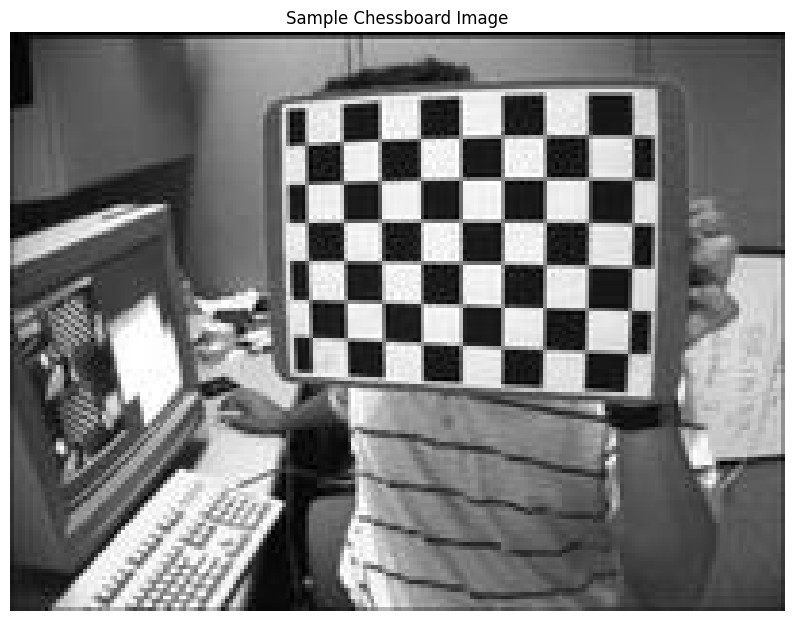

In [12]:
# Download sample chessboard images
img_urls = [f"https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left{i:02d}.jpg" for i in range(1, 10)]
calib_dir = 'calib_images'
os.makedirs(calib_dir, exist_ok=True)

for url in img_urls:
    filename = os.path.join(calib_dir, os.path.basename(url))
    if not os.path.exists(filename):
        pil_image = await learn_tools.get_image(img_url=url, padding=0)
        pil_image.save(filename, 'JPEG')

# Display a sample image
sample_image = cv2.imread(os.path.join(calib_dir, 'left01.jpg'))
learn_tools.show_multiple_images([
    {'title': 'Sample Chessboard Image', 'image': sample_image}
])

## 🔹 Prepare Object and Image Points

Define the 3D coordinates of chessboard corners (object points) and detect 2D corners in images (image points).

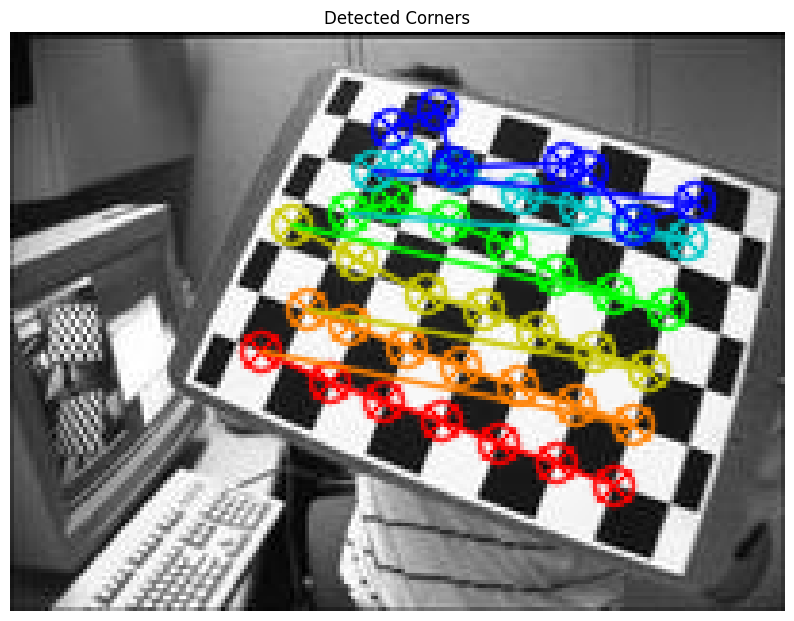

Found corners in 7 images.


In [13]:
# Termination criteria for subpixel accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Object points for 7x6 chessboard
objp = np.zeros((6*7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob('calib_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw on last image
        if fname == images[-1]:
            cv2.drawChessboardCorners(img, (7,6), corners2, ret)
            learn_tools.show_multiple_images([
                {'title': 'Detected Corners', 'image': img}
            ])
print(f'Found corners in {len(objpoints)} images.')

## 🔹 Camera Calibration

Solve for intrinsic matrix, distortion coefficients, and extrinsic parameters using OpenCV's `calibrateCamera`.

In [14]:
img_shape = cv2.imread(images[0]).shape[:2][::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
print('Camera Matrix:\n', mtx)
print('Distortion Coefficients:\n', dist)
print('Reprojection Error:', ret)

Camera Matrix:
 [[ 3.82620750e+02  0.00000000e+00  1.08248586e+02]
 [ 0.00000000e+00  1.15707173e+03 -3.86452124e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Distortion Coefficients:
 [[-5.79233764e+00 -7.21739114e+00  3.85854660e-01  1.89761365e-01
   1.36204156e+03]]
Reprojection Error: 4.491309477468247


## 🔹 Undistort Images

Use `cv2.getOptimalNewCameraMatrix` to compute new camera matrix and remove distortions.

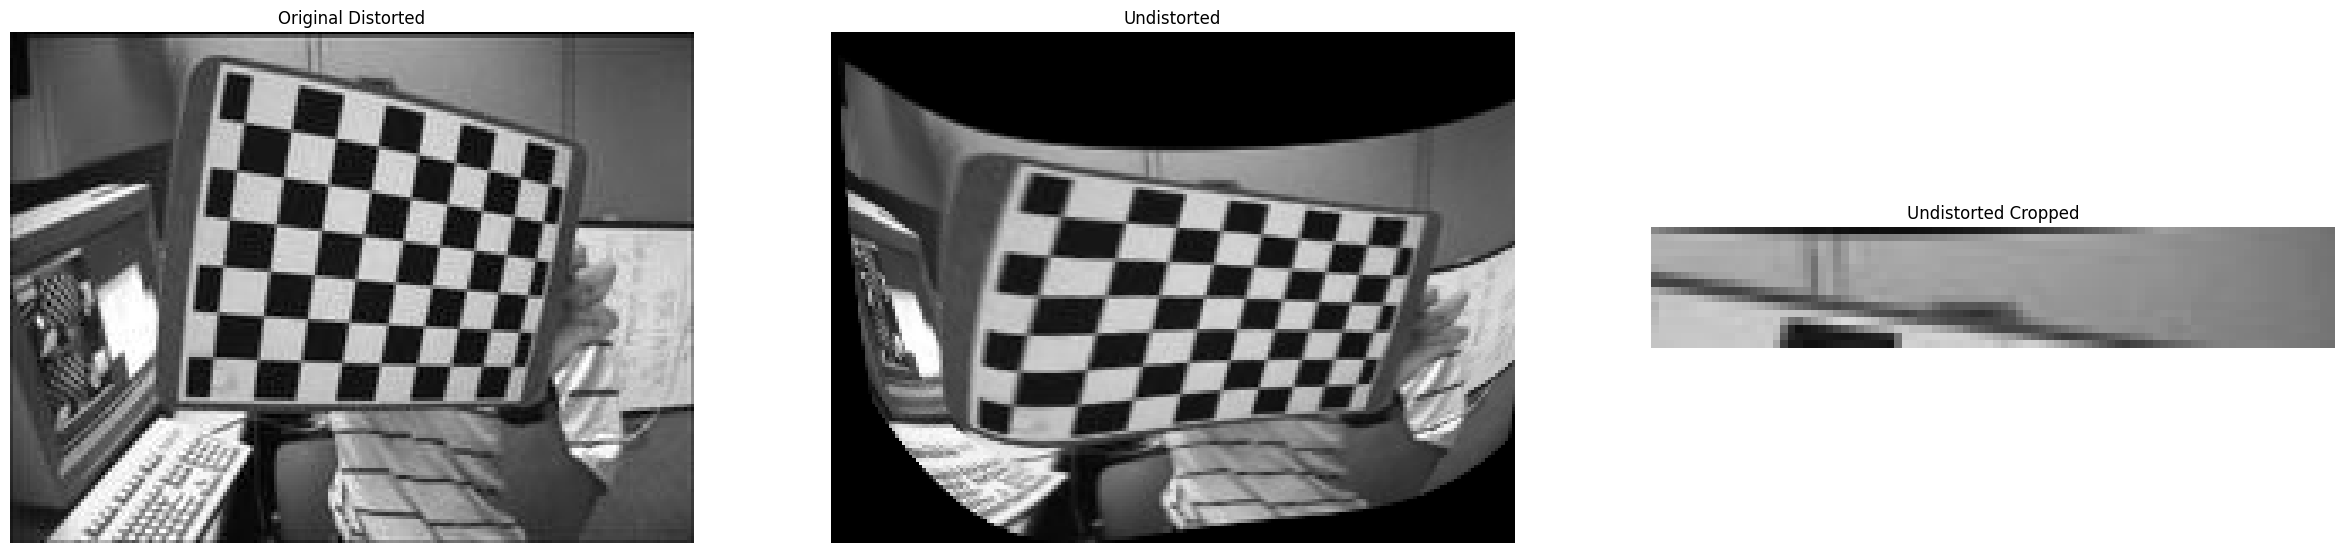

In [15]:
test_img = cv2.imread('calib_images/left09.jpg')
h, w = test_img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
dst = cv2.undistort(test_img, mtx, dist, None, newcameramtx)
x, y, w_roi, h_roi = roi
dst_cropped = dst[y:y+h_roi, x:x+w_roi]
learn_tools.show_multiple_images([
    {'title': 'Original Distorted', 'image': test_img},
    {'title': 'Undistorted', 'image': dst},
    {'title': 'Undistorted Cropped', 'image': dst_cropped}
])

## 🔹 Compute Reprojection Error

Evaluate calibration quality by projecting object points back into images and comparing with detected corners.

In [16]:
mean_error = 0
for i in range(len(objpoints)):
    imgpts2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpts2, cv2.NORM_L2) / len(imgpts2)
    mean_error += error
mean_error /= len(objpoints)
print(f'Average Reprojection Error: {mean_error:.4f} pixels')

Average Reprojection Error: 0.6834 pixels


## 🔹 Save and Load Calibration Parameters

Persist calibration data for reuse without recalibrating every time.

In [17]:
np.savez('camera_calib.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
with np.load('camera_calib.npz') as data:
    mtx_loaded = data['mtx']
    dist_loaded = data['dist']
print('Loaded Camera Matrix:\n', mtx_loaded)

Loaded Camera Matrix:
 [[ 3.82620750e+02  0.00000000e+00  1.08248586e+02]
 [ 0.00000000e+00  1.15707173e+03 -3.86452124e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 🔹 Advanced Use Cases

- **Fisheye lens calibration**: Use `cv2.fisheye.calibrate` for wide-angle lenses.
- **Stereo calibration**: Use `cv2.stereoCalibrate` for depth and 3D reconstruction.
- Combine calibration with `cv2.solvePnP` to overlay 3D models (AR) or measure distances precisely.